<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


# **CNNs: convolutional neural networks (part 2)**

#### **Morning contents/agenda**

1. Commonly used datasets in computer vision

2. Important CNN architectures

3. U-nets and upsampling (unpooling & transpose convolutions)

4. Transfer learning

5. Summary of CNNs

#### **Learning outcomes**

1. Awareness of well-established CNN architectures

2. Undersand how to upsample data

3. Understand how and why transfer learning is used

#### **Afternoon contents/agenda**

1. Inspection of CNN filters

2. Transfer learning from ImageNet to Bees and Ants

#### **Learning outcomes**

1. Become familiar with the effect that filters have (sometimes you can interpret them, sometimes they have abstracted the data too far to develop intuitions)

2. Hands-on knowledge on how to apply transfer learning


<br/>

---

<br/>

In [72]:
!pip install pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

Populating the interactive namespace from numpy and matplotlib


In [73]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## 1. Inspection of CNN filters

Pytorch provides users with a rich set of pre-trained neural network architectures. These have mostly been pre-trained on imagenet.   
[```torchvision.models```](https://pytorch.org/vision/stable/models.html) provides us with an interface to these pretrained deep neural networks.

- Load a pretrained [AlexNet](https://arxiv.org/abs/1404.5997) model from ```torchvision.models``` ([Source Code](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html) for AlexNet in Pytorch).

- Obtain the weight kernels of the first and second convolutional layers and display them.

- Do it again for one (or more) layer of a ResNet18 model and/or any other model you like.

In [74]:
from torchvision import models
from torchsummary import summary

alexnet = models.alexnet(pretrained=True).to(device)### instantiate a pretrained alexnet
### print alexnet
print(alexnet)
### print a summary of alexnet
summary(alexnet, input_size=(3,100,100))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [75]:
alexnet.features[3]

Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

In [76]:
alexnet.features[0].weight.data

tensor([[[[ 1.1864e-01,  9.4069e-02,  9.5435e-02,  ...,  5.5822e-02,
            2.1575e-02,  4.9963e-02],
          [ 7.4882e-02,  3.8940e-02,  5.2979e-02,  ...,  2.5709e-02,
           -1.1299e-02,  4.1590e-03],
          [ 7.5425e-02,  3.8779e-02,  5.4930e-02,  ...,  4.3596e-02,
            1.0225e-02,  1.3251e-02],
          ...,
          [ 9.3155e-02,  1.0374e-01,  6.7547e-02,  ..., -2.0277e-01,
           -1.2839e-01, -1.1220e-01],
          [ 4.3544e-02,  6.4916e-02,  3.6164e-02,  ..., -2.0248e-01,
           -1.1376e-01, -1.0719e-01],
          [ 4.7369e-02,  6.2543e-02,  2.4758e-02,  ..., -1.1844e-01,
           -9.5567e-02, -8.3890e-02]],

         [[-7.2634e-02, -5.7996e-02, -8.0661e-02,  ..., -6.0304e-04,
           -2.5309e-02,  2.5471e-02],
          [-6.9042e-02, -6.7562e-02, -7.6367e-02,  ..., -3.9616e-03,
           -3.0402e-02,  1.0477e-02],
          [-9.9517e-02, -8.5592e-02, -1.0521e-01,  ..., -2.6587e-02,
           -2.2777e-02,  6.6451e-03],
          ...,
     

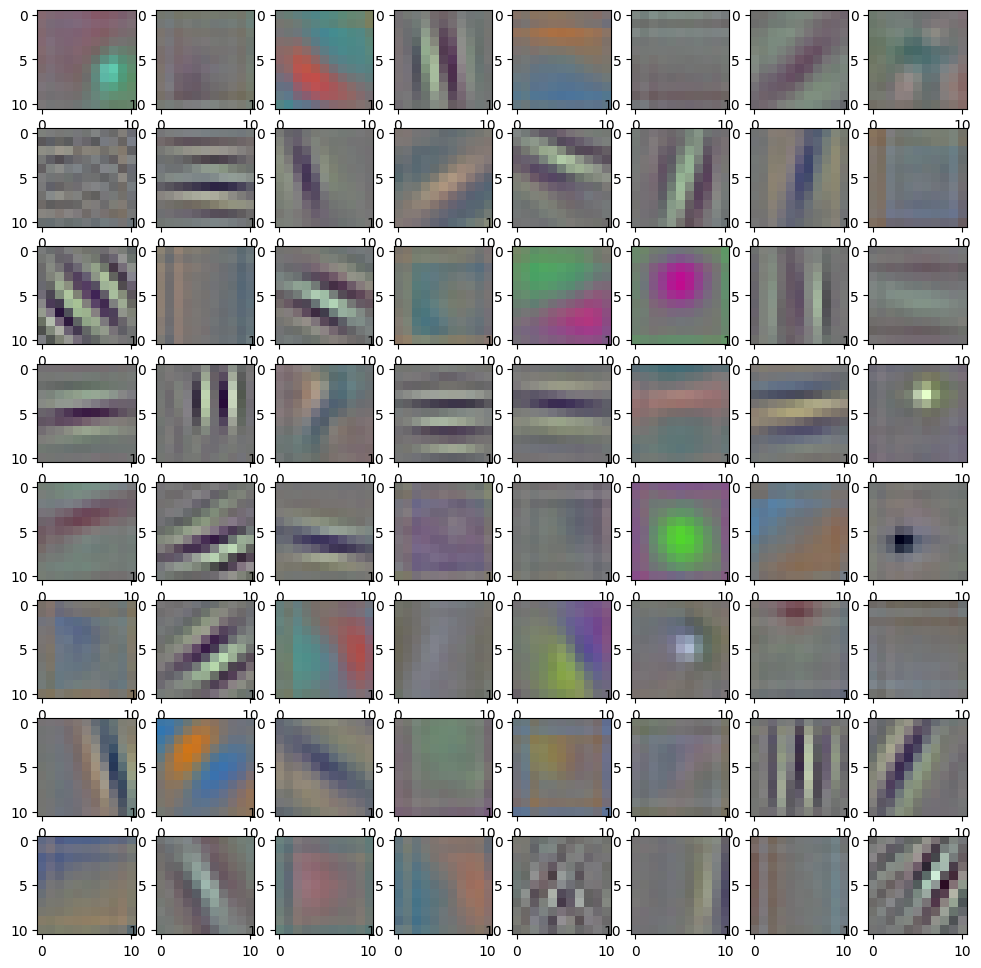

In [77]:
first_layer = alexnet.features[0]### extract the features of the first layer
### print the first layer
weights = alexnet.features[0].weight.data### extract weights from the first layer

# Normalisation for plotting because imshow does not like negative values
min_w, max_w =  weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

# plot the filters:
fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()
for ax, kernel in zip(axarr, weights.cpu().numpy()):  # need to send the weights to the cpu for plotting
  ax.imshow(np.swapaxes(kernel, 0, 2))

torch.Size([192, 64, 5, 5])

filters:  32



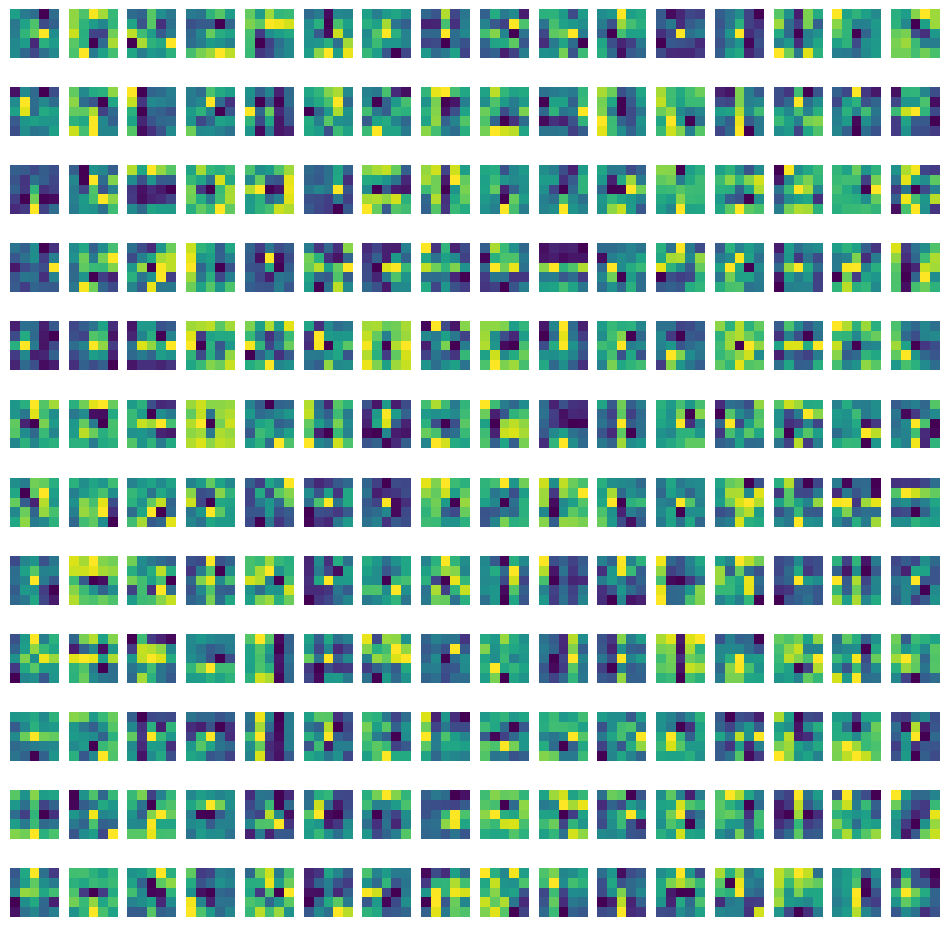

In [78]:
secondconv_layer = alexnet.features[3]### extract the features of the second convolutional layer
### print the layer
weights = alexnet.features[3].weight.data### extract weights
print(weights.shape)  ### check it has the shape you expect

# Normalisation for plotting because imshow does not like negative values
min_w, max_w =  weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

fig, axarr = plt.subplots(12, 16, figsize=(12, 12))
axarr = axarr.flatten()
filter_chan = 32### define which channel you want to plot
print("")
print("filters: ", filter_chan)
print("")
for ax, kernel in zip(axarr, weights[:,filter_chan,:,:].cpu().numpy()):
  ax.imshow(kernel)#np.swapaxes(kernel, 0, 2))
  ax.set_axis_off()

And now for the `resnet`:

In [79]:
resnet = models.resnet18(pretrained=True).to(device)### get an instance of a pre-trained resnet
print(resnet)
### print it
### print the summary
summary(resnet, input_size=(3,100,100))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [80]:
resnet.conv1.weight.data

tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01],
          ...,
     

torch.Size([64, 3, 7, 7])
shape of weights:  torch.Size([64, 3, 7, 7])


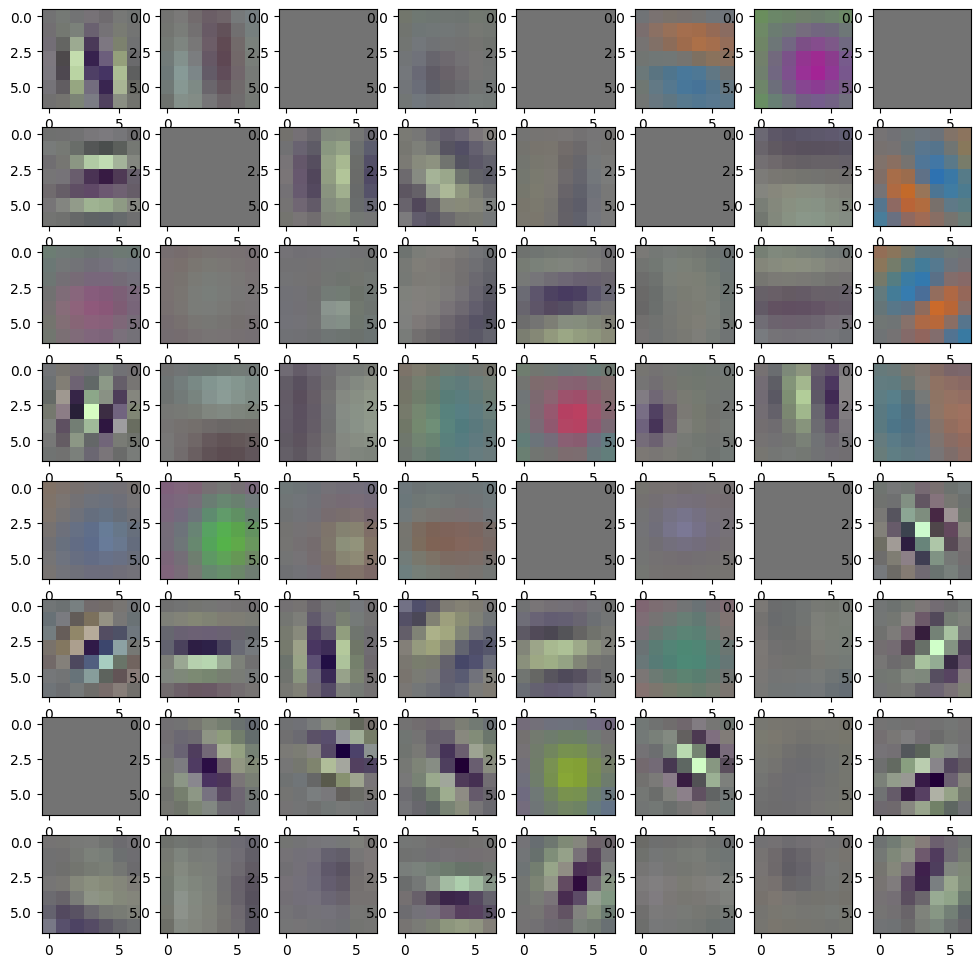

In [81]:
first_layer = resnet.conv1### extract first layer features
### print first layer
weights = resnet.conv1.weight.data### extract weights
print(weights.shape) ### print shape of weights

# Normalisation for plotting because imshow does not like negative values
min_w, max_w =  weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

print('shape of weights: ', weights.shape)

fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()

for ax, kernel in zip(axarr, weights.cpu().numpy()):   # plot the three channels at the same
  ax.imshow(np.swapaxes(kernel, 0, 2))                 # time as an RGB image
  #ax.imshow(kernel)                                  # imshow does not like this shape (that's why we swap the axes in the line above)


# for ax, kernel in zip(axarr, weights[:,1,:,:].cpu().numpy()):  # plot one channel at a time
#   ax.imshow(kernel)                                            # (second dimension of the tensor)

We can also try the `inception_v3` model:

In [82]:
### your code goes here
inception = models.inception_v3(pretrained=True).to(device)
print(inception)
summary(inception, input_size=(3,300,300))

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [83]:
inception.Conv2d_1a_3x3.conv

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
torch.Size([32, 3, 3, 3])
shape of weights:  torch.Size([32, 3, 3, 3])


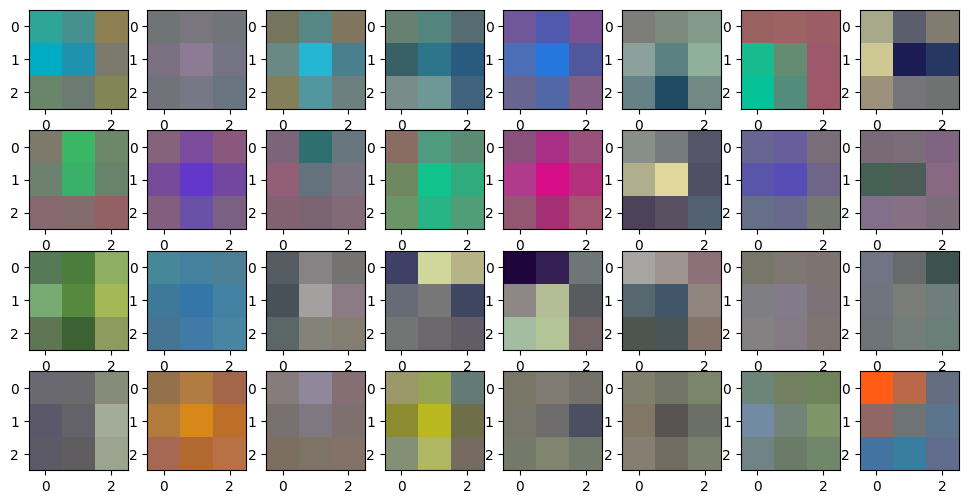

In [84]:
### your code goes here
first_layer = inception.Conv2d_1a_3x3.conv
print(first_layer)
weights = inception.Conv2d_1a_3x3.conv.weight.data
print(weights.shape)

min_w,max_w = weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

print('shape of weights: ', weights.shape)

fig,axarr = plt.subplots(4, 8, figsize=(12,6))
axarr = axarr.flatten()
for ax, kernel in zip(axarr, weights.cpu().numpy()):   # plot the three channels at the same
  ax.imshow(np.swapaxes(kernel, 0, 2))

## 2. Transfer learning from ImageNet to Bees and Ants
\[*adapted from [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)*\]

The basic principle behind transfer learning is to leverage features learned on one dataset and recycle them to perform tasks on another dataset.

Instead of training a network from randomly initialised weights, we start from a network with weights trained in a different domain and fine-tune it to a different source task. By doing this, the weights of the network already have useful properties that can improve optimisation.

To be able to apply transfer learning effectively, the data distribution of the data that a very powerful model was trained on should follow a similar distribution as the other dataset that we are trying to apply transfer learning to.    

For example:  
_We want to create a new classifier for cats and dogs given only a small set of say 100 training images of each category._

Large neural networks that have been trained on ImageNet or CIFAR have similar categories in their dataset, say horses and maybe cows and many more categories of natural images.  

The rationale is that since we've already learned a set of efficient filters on ImageNet, we can simply use a deep network as a feature extractor and only retrain the final layer —or alternatively fine tune all layers- of a given network to adapt it to our particular task


Transfer learning is a powerful tool because it can:
- prevent poor training from random weights when only small datasets are available.
- reduce training time for tasks that use data with 'similar' distributions

<br>

We will apply transfer learning to a small dataset containing images of bees and ants by transfering learning done by training with the ImageNet dataset.

ImageNet is arguably the most popular dataset for benchmarking classification models. It contains around 14 million annotated natural images spread over 22 thousand categories. Images are of size 3 x 224 x 224, with normalised means and stds of [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225]. In transfer learning is common practice to use the means and standard deviations of the data used for pretraining to normalise the new dataset. Note that the most popular networks (VGG, ResNet, AlexNet, etc..) have been design to take as input 3 x 224 x 224 images to accomodate for ImageNet.

<br>

<p style="text-align:center;"><img src="https://paperswithcode.com/media/datasets/ImageNet-0000000008-f2e87edd_Y0fT5zg.jpg" alt="drawing" width="600"/>
<i>ImageNet samples</i>
</p>

<br>



Perform the following tasks:

0. Adapt the training, validation and evaluation functions to the appropriate input size

1. [Download](https://download.pytorch.org/tutorial/hymenoptera_data.zip) the dataset into your current directory (you can do it using the code provided below). Use [```torchvision.datasets.ImageFolder```](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html) to load the training and validation data into a Pytorch ```Dataset```. Investigate and visualize a few examples of the dataset. Remember to transform the data into a tensor. What other pre-processing is required?

2. Instantiate an untrained ResNet18 from [```torchvision.models```](https://pytorch.org/vision/stable/models.html). Reinitialise the last connected layer ```model.fc``` with a new fully connected layer with appropriate input and output sizes

3. Train the newly initialised ResNet from scratch. What do you notice?

4. Now instantiate the pre-trained ReseNet18 by passing the argument ``pretrained=True`` and perform fine-tuning using a smaller learning rate of ```1e-3```

5. Use the provided ``set_parameters_requires_grad`` and ``get_params_to_update`` functions to repeat the step above but now freezing optimisation for all layers except the final classifying layer (instead of retraining the whole network with a smaller learning rate).

6. Finally, train a ResNet on MNIST from scratch and use those weights to repeat step 5 on the bees and ants dataset. Is this a suitable problem?

In [85]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### 2.0 Adapting training, validation and evaluation functions to our problem size

In [86]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3,224,224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

### 2.1 Loading and Visualising the Data

In [87]:
!wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip && unzip -oq hymenoptera_data.zip

File ‘hymenoptera_data.zip’ already there; not retrieving.



In [88]:
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [89]:
from torchvision import datasets, transforms, models

transform = transforms.Compose([
        transforms.ToTensor(),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=transform)

print(train_ds)
print(train_ds.classes)
print(train_ds.class_to_idx)
print(train_ds[0]) # an example of calling  __getitem__, which is what the dataloader does
print(train_ds.samples[0]) # get image path inside samples
print("\n\n")

# Get mean and std
tmp_loader = DataLoader(train_ds, batch_size=1, num_workers=0)
data = next(iter(tmp_loader))
mean = [torch.mean(data[0][0][i].flatten()).item() for i in range(3)]
std = [torch.std(data[0][0][i].flatten()).item() for i in range(3)]
print(mean, std)

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./hymenoptera_data/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
['ants', 'bees']
{'ants': 0, 'bees': 1}
(tensor([[[0.3137, 0.3137, 0.3137,  ..., 0.3176, 0.3098, 0.2980],
         [0.3176, 0.3176, 0.3176,  ..., 0.3176, 0.3098, 0.2980],
         [0.3216, 0.3216, 0.3216,  ..., 0.3137, 0.3098, 0.3020],
         ...,
         [0.3412, 0.3412, 0.3373,  ..., 0.1725, 0.3725, 0.3529],
         [0.3412, 0.3412, 0.3373,  ..., 0.3294, 0.3529, 0.3294],
         [0.3412, 0.3412, 0.3373,  ..., 0.3098, 0.3059, 0.3294]],

        [[0.5922, 0.5922, 0.5922,  ..., 0.5961, 0.5882, 0.5765],
         [0.5961, 0.5961, 0.5961,  ..., 0.5961, 0.5882, 0.5765],
         [0.6000, 0.6000, 0.6000,  ..., 0.5922, 0.5882, 0.5804],
         ...,
         [0.6275, 0.6275, 0.6235,  ..., 0.3608, 0.6196, 0.6157],
         [0.6275, 0.6275, 0.6235,  ..., 0.5765, 0.6275, 0.5961],
         [0.6275, 0.6275, 0.6235,  ...,

In [90]:
def show_batch(dataset, nr=4, nc=4):
  fig, axarr = plt.subplots(nr, nc, figsize=(10, 10))
  for i in range(nr):
      for j in range(nc):
          idx = random.randint(0, len(train_ds))
          sample, target = train_ds[idx]
          try:
            axarr[i][j].imshow(sample) # if PIL
          except:
            axarr[i][j].imshow(sample.permute(1,2,0)) # if tensor of shape CHW
          target_name = train_ds.classes[target]
          axarr[i][j].set_title("%s (%i)"%(target_name, target))

  fig.tight_layout(pad=1.5)
  plt.show()

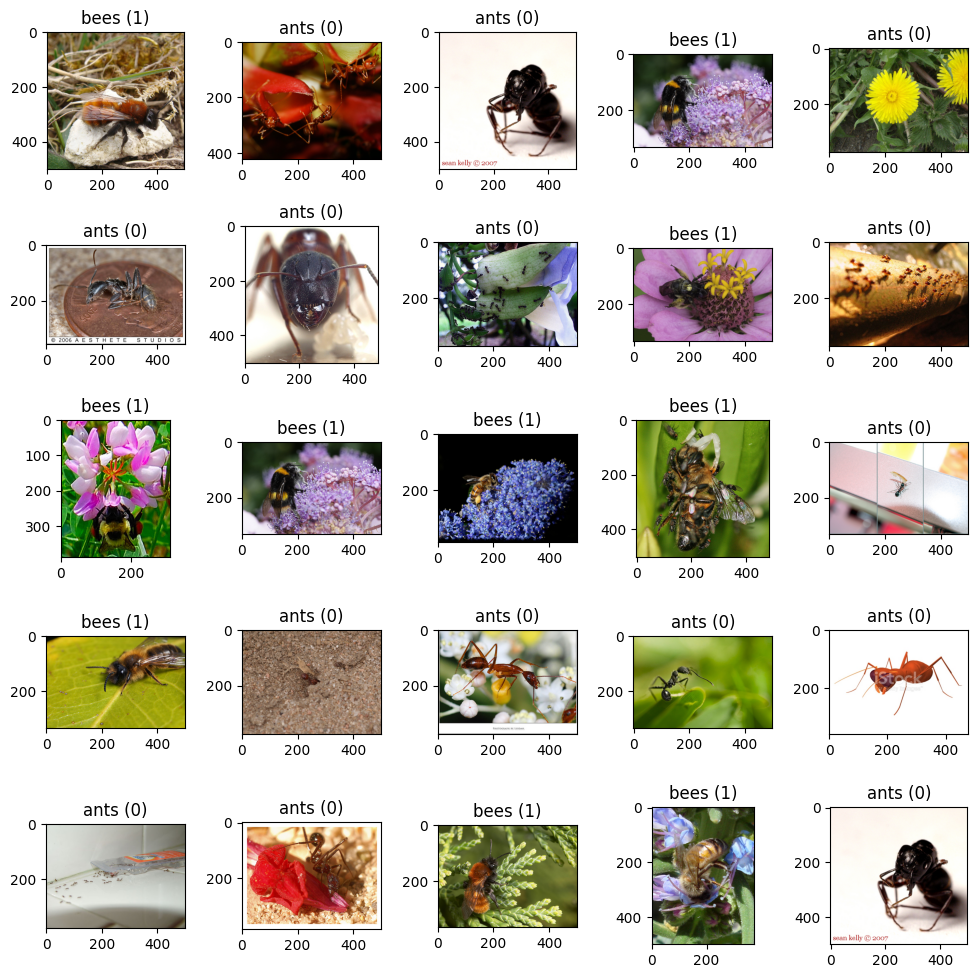

In [91]:
show_batch(train_ds, 5, 5)

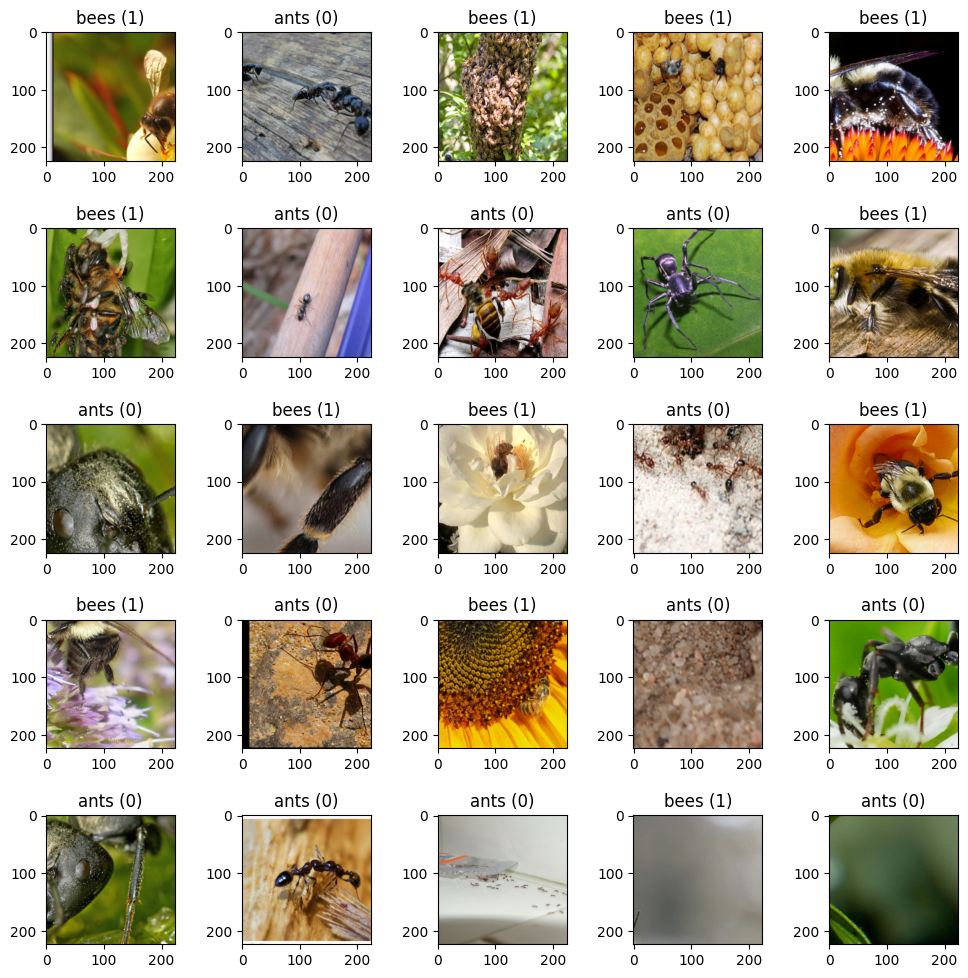

In [92]:
# Fix image sizes with transforms
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),### add a transform that does a random crop with the right size here
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

show_batch(train_ds, 5, 5)

In [95]:
# Finally add normalisation to transforms
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224), ### add a transform that does a random crop with the right size here
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)### create a training ImageFolder
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)### create a testing ImageFolder

# Create dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size ,shuffle=True, num_workers=0)### create a dataloader for the training data
test_loader =  DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)### create a dataloader for the testing data

### 2.2 Training a newly initialized Resnet18


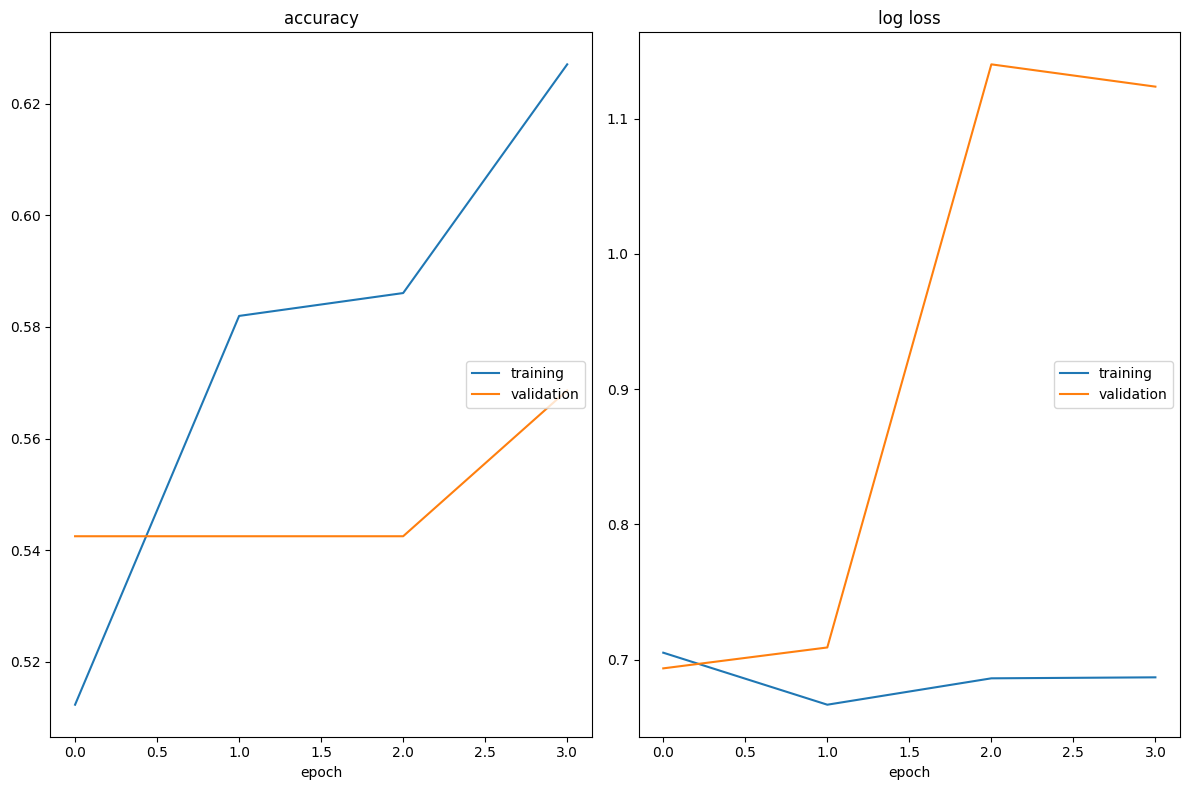

accuracy
	training         	 (min:    0.512, max:    0.627, cur:    0.627)
	validation       	 (min:    0.542, max:    0.569, cur:    0.569)
log loss
	training         	 (min:    0.667, max:    0.705, cur:    0.687)
	validation       	 (min:    0.694, max:    1.140, cur:    1.124)


KeyboardInterrupt: ignored

In [94]:
set_seed(seed)

model = models.resnet18().to(device)
print(model)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)  ### this line is provided, but what does it do?

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)### define your optimiser (SGC with momentum)
criterion = nn.CrossEntropyLoss()### define your loss

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_baseline.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}"
torch.save(model.state_dict(), path)

Our model is not doing too well. The lack of data is taking a toll on our training and giving a large generalisation error.

### 2.3 Finetuning a pre-trained Resnet

In [ ]:
set_seed(seed)

train_transform = transforms.Compose([
        ### add a transform that does a random crop with the right size here
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)

optimizer = ### define your optimiser (SGC with momentum) and make sure to adapt the learning rate to 'fine-tune' the network
criterion = ### define your loss

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_imagenet_finetune.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}"
torch.save(model.state_dict(), path)

This is much better now.

### 2.4 Pre-trained Resnet with retrained last layer

Use the following provided functions:

In [ ]:
def set_parameter_requires_grad(model, requires_grad=False):
    """https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html"""
    for param in model.parameters():
        param.requires_grad = requires_grad
    return None

def get_params_to_update(model):
    """ Returns list of model parameters that have required_grad=True"""
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

to adapt the training to only update the last layer of the network

In [ ]:
set_seed(seed)

train_transform = transforms.Compose([
        ### add a transform that does a random crop with the right size here
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = ### get an instance of a pre-trained resnet-18
### use the provdied set_parameter_requires_grad to disable training
model.fc = ### add a last layer of the network that you need. Newly initialised layers automatically have requires_grad=True

optimizer = ### define optimiser and use the provided get_params_to_update function to tell it to only update what you want
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_imagenet_feature_extract.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}"
torch.save(model.state_dict(), path)

<img src="https://pbs.twimg.com/media/Ev-f6AaU8AgMeRd.jpg" alt="drawing" width="600"/>

### 2.5 What if pretrained on MNIST instead?

Training a Resnet on MNIST from scratch

In [ ]:
train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.expand(3, 224, 224)),   # expand to 3 channels
    ])
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.expand(3, 224, 224)),   # expand to 3 channels
    ])

mnist_train = MNIST("./", download=True, train=True, transform=train_transform)
mnist_test = MNIST("./", download=True, train=False, transform=test_transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)

model = models.resnet18().to(device)
model.fc = ### add the last layer you need here

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()


### ~ 7 min per epoch here ###
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

model_save_name = 'resnet18_mnist_classifier_full_training_set_baseline_.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}"
torch.save(model.state_dict(), path)


test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

### 2.6 Transfer learning on the ResNet pretrained on MNIST


In [ ]:
set_seed(seed)

train_transform = transforms.Compose([
        ### add a transform that does a random crop with the right size here
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081]),
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1307, 0.1307, 0.1307], [0.229, 0.3081, 0.3081]),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = models.resnet18().to(device)
model.fc = nn.Linear(model.fc.in_features, 10).to(device)
path = F"/content/gdrive/My Drive/models/{model_save_name}"
model.load_state_dict(torch.load(path))
model.fc = #### add the last layer you need here

optimizer = ### use SGD and fine-tune your network
criterion = ### define your loss

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

model_save_name = 'resnet18_bees_and_antes_classifier_full_training_set_mnist_transfer.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}"
torch.save(model.state_dict(), path)


test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")



As expected, hand-written digits and bees do not share data distribution shapes.

<br>
<br>
<br>
<br>

---
---

## ***Clarifying issues with loss averaging:***

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0) ## this undoes normalisation
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

The cross entropy loss provided by PyTorch has a normalisation added to it:

[`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

This line:

`train_loss += loss*X.size(0)`

undoes the normalisation done by `torch.nn.CrossEntropyLoss` and adds the value to the accumulated losses over minibatches.

Then, once we have gone over all the data (that is, over all the minibatches), we will have completed one epoch, and we want to know the value of the normalised loss. To get it, we divide it by the total number of samples in my data:

`return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)`

A similar business is going on with the accuracy. In this case we use scikit-learn:

[`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

where we do:

`train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)`

and then we divide the accuracy by the total length of the data.

<br>
<br>

Finally, this line before the data_loader is iterated:

`train_loss, train_accuracy = 0, 0`

resets the value of the loss value at every epoch.


---

## Alternative implementations:

Simply modify the default behaviour of the loss and the accuracy calculations:

`torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=- 100, reduce=None, `**`reduction='mean'`**`, label_smoothing=0.0)`

change default to **`reduction='sum'`** when you define the loss.

<br>

And for the accuracy, just change the line:

`train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(),`**`normalize=False`**`)`

### **Now I just accumulate the sum of the loss, so it is naturally scaled to the batch size**